### Import all required libraries

In [1]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import OLSInfluence

### Data Loading


Only the 'advert_bbc4_bees_1024x576' folder and its contents (audio, event_data, video) are used. Please ensure you have downloaded this folder and placed it in the 'data/DIEM-data/' directory before running.

In [2]:
#Folder with the downloaded data in 
main_dir = "data/DIEM-data/"
data = {}
#Loop through all the videos
for video in os.listdir(main_dir):
    video_path = os.path.join(main_dir, video, "event_data")
    if os.path.exists(video_path):
        #Data for each video saved with folder name as key in dictionary
        data[video] = []
        #Loop through each participant
        for participant in os.listdir(video_path):
            participant_path = os.path.join(video_path, participant)
            #Append to list of participants data 
            data[video].append(pd.read_csv(participant_path, delimiter="\t").to_numpy())
        data[video] = np.array(data[video])
        p, fr, f = data[video].shape
        print("loaded:", video, "participants:", p, "frames:", fr)

loaded: advert_bbc4_bees_1024x576 participants: 42 frames: 1215


### Data Formatting 

Combine data from all participants into a comprehensive DataFrame, labeling each column appropriately. Additionally, introduce a column to denote each participant's ID, extracted from the filename. 

For instance, in 'diem1s01.asc_3_advert_bbc4_bees_1024x576.txt', '01' serves as the participant's ID. This aggregated DataFrame will facilitate further analysis.

In [3]:
#load the folder
folder_path = 'data/DIEM-data/advert_bbc4_bees_1024x576/event_data'
#list all filenames in the folder, ref：https://www.geeksforgeeks.org/python-os-listdir-method/
files = os.listdir(folder_path)

#initialize an empty DataFrame
df_total = pd.DataFrame()
#loop through each file in the folder
for file in files:
    #combine folder_path and file to create a path string recognizable by the OS
    file_path = os.path.join(folder_path, file)
    #read the text file and convert it to a DataFrame, using tab '\t' as the field delimiter and specifying column names
    df = pd.read_csv(file_path, delimiter='\t', names=['frame', 'left_x', 'left_y', 'left_dil', 'left_event', 'right_x', 'right_y', 'right_dil', 'right_event'])
    #use a regular expression to match the participant number in the filename,ref:https://www.guru99.com/python-regular-expressions-complete-tutorial.html
    match = re.search(r'\.asc_(\d+)_', file)
    #assign the extracted participant number to the variable participant_id
    participant_id = match.group(1)     
    #set the found or defined participant number for each row
    df['participant'] = participant_id
    #merge the current file's DataFrame into the total DataFrame 
    df_total = pd.concat([df_total, df])

#display the DataFrame's column names
print(df_total.columns)
df

Index(['frame', 'left_x', 'left_y', 'left_dil', 'left_event', 'right_x',
       'right_y', 'right_dil', 'right_event', 'participant'],
      dtype='object')


,frame,left_x,left_y,left_dil,left_event,right_x,right_y,right_dil,right_event,participant
0,1,0.0,0.0,0.0,0,518.7,1200.0,1000.0,1,24
1,2,0.0,0.0,0.0,0,637.3,541.3,1469.0,1,24
2,3,654.4,475.4,1296.0,1,613.3,440.2,1541.0,1,24
3,4,665.2,489.0,1298.0,1,612.1,496.0,1541.0,1,24
4,5,661.1,487.7,1304.0,1,623.4,481.7,1543.0,1,24
...,...,...,...,...,...,...,...,...,...,...
1211,1212,654.9,479.4,1197.0,1,596.6,458.6,1486.0,1,24
1212,1213,650.1,480.2,1198.0,1,604.7,461.6,1498.0,1,24
1213,1214,625.6,441.5,1197.0,1,588.6,435.0,1505.0,1,24
1214,1215,617.9,456.1,1197.0,1,580.5,435.8,1506.0,1,24


The DataFrame, showing only 1216 rows, likely contains more data, truncated for display. We'll verify by checking the total row count and unique participant IDs.

In [4]:
#check the total number of rows in the DataFrame
print(f"Total rows : {df_total.shape[0]}")

#check the number of unique participants
unique_participants = df_total['participant'].unique()
print(f"Unique participant IDs: {unique_participants}")
print(f"Number of unique participants: {len(unique_participants)}")

Total rows : 51072
Unique participant IDs: ['23' '2' '5' '24' '3' '13' '7' '19' '21' '1' '15' '20' '12' '8' '6' '9'
 '4' '11' '22' '18' '16']
Number of unique participants: 21


### Data Cleaning

In [5]:
#handle missing values
df_total.dropna(inplace=True)
#remove duplicate rows
df_total.drop_duplicates(inplace=True)

#all values should be within the screen size range
screen_width = 1024
screen_height = 576
#check if x coordinates are between 0 and screen_width
df_total = df_total[(df_total['left_x'].between(0, screen_width)) & (df_total['right_x'].between(0, screen_width))]
#check if y coordinates are between 0 and screen_height
df_total = df_total[(df_total['left_y'].between(0, screen_height)) & (df_total['right_y'].between(0, screen_height))]

In [6]:
#check the total number of rows in the DataFrame
print(f"Total rows : {df_total.shape[0]}")

#check the number of unique participants
unique_participants = df_total['participant'].unique()
print(f"Unique participant IDs: {unique_participants}")
print(f"Number of unique participants: {len(unique_participants)}")

Total rows : 37287
Unique participant IDs: ['23' '2' '5' '24' '3' '13' '7' '19' '21' '1' '15' '20' '12' '8' '6' '9'
 '4' '11' '22' '18' '16']
Number of unique participants: 21


After the data cleaning process, we noticed a reduction of 13,785 rows. A detailed review of the cleaning steps revealed that missing values mainly stemmed from eye-tracking data points falling outside the screen's boundary range, which were consequently filtered out. This could be due to device malfunctions or calibration errors. 

### Making new features 

In [7]:
#calculate the average eye coordinates to obtain the center point of the participant's gaze
df_total['avg_x'] = (df_total['left_x'] + df_total['right_x']) / 2
df_total['avg_y'] = (df_total['left_y'] + df_total['right_y']) / 2

#calculate the difference in pupil size between the left and right eyes
df_total['diff_dil'] = abs(df_total['left_dil'] - df_total['right_dil'])

#calculate the Euclidean distance between the left and right eyes, which can reflect the synchrony of eye movements,ref:https://stackoverflow.com/questions/5228383/how-do-i-find-the-distance-between-two-points
df_total['eye_dist'] = np.sqrt((df_total['left_x'] - df_total['right_x'])**2 + (df_total['left_y'] - df_total['right_y'])**2)

#calculate the speed of the left and right eyes between consecutive frames, adding a NaN at the start as a placeholder,ref:https://numpy.org/doc/stable/reference/generated/numpy.diff.html
df_total['left_eye_speed'] = np.sqrt(np.diff(df_total['left_x'], prepend=np.nan)**2 + np.diff(df_total['left_y'], prepend=np.nan)**2)
df_total['right_eye_speed'] = np.sqrt(np.diff(df_total['right_x'], prepend=np.nan)**2 + np.diff(df_total['right_y'], prepend=np.nan)**2)

#for each participant, count the occurrences of different event types
df_total['error_count'] = df_total.groupby('participant')['left_event'].transform(lambda x: (x == -1).sum())
df_total['blink_count'] = df_total.groupby('participant')['left_event'].transform(lambda x: (x == 0).sum())
df_total['fixation_count'] = df_total.groupby('participant')['left_event'].transform(lambda x: (x == 1).sum())
df_total['saccade_count'] = df_total.groupby('participant')['left_event'].transform(lambda x: (x == 2).sum())

In [8]:
#print the shape of the DataFrame 
print("Shape of DataFrame:", df_total.shape)
#print the column names
print("Column names:", df_total.columns.tolist())

Shape of DataFrame: (37287, 20)
Column names: ['frame', 'left_x', 'left_y', 'left_dil', 'left_event', 'right_x', 'right_y', 'right_dil', 'right_event', 'participant', 'avg_x', 'avg_y', 'diff_dil', 'eye_dist', 'left_eye_speed', 'right_eye_speed', 'error_count', 'blink_count', 'fixation_count', 'saccade_count']


### Summarising variables

In [9]:
#calculate descriptive statistics for numerical variables
print(df_total.describe())

              frame        left_x        left_y      left_dil    left_event  \
count  37287.000000  37287.000000  37287.000000  37287.000000  37287.000000   
mean     615.198595    628.756513    408.504243   1137.399523      1.056159   
std      363.818673    224.363747    124.969867    454.572392      0.421694   
min        1.000000      0.000000      0.000000      0.000000     -1.000000   
25%      293.000000    543.050000    358.300000    909.000000      1.000000   
50%      652.000000    640.800000    439.900000   1161.000000      1.000000   
75%      935.000000    750.000000    495.400000   1407.000000      1.000000   
max     1216.000000   1024.000000    576.000000   2605.000000      2.000000   

            right_x       right_y     right_dil   right_event         avg_x  \
count  37287.000000  37287.000000  37287.000000  37287.000000  37287.000000   
mean     634.093719    412.215877   1130.064741      0.952825    631.425116   
std      220.005038    118.028217    460.409691    

In [10]:
#view the data types of each variable
print(df_total.dtypes)

frame                int64
left_x             float64
left_y             float64
left_dil           float64
left_event           int64
right_x            float64
right_y            float64
right_dil          float64
right_event          int64
participant         object
avg_x              float64
avg_y              float64
diff_dil           float64
eye_dist           float64
left_eye_speed     float64
right_eye_speed    float64
error_count          int64
blink_count          int64
fixation_count       int64
saccade_count        int64
dtype: object


### Plotting data

##### 1. Basic charts are used to initially examine the distributions of key variables in eye-tracking data, providing an initial understanding to guide further exploration.

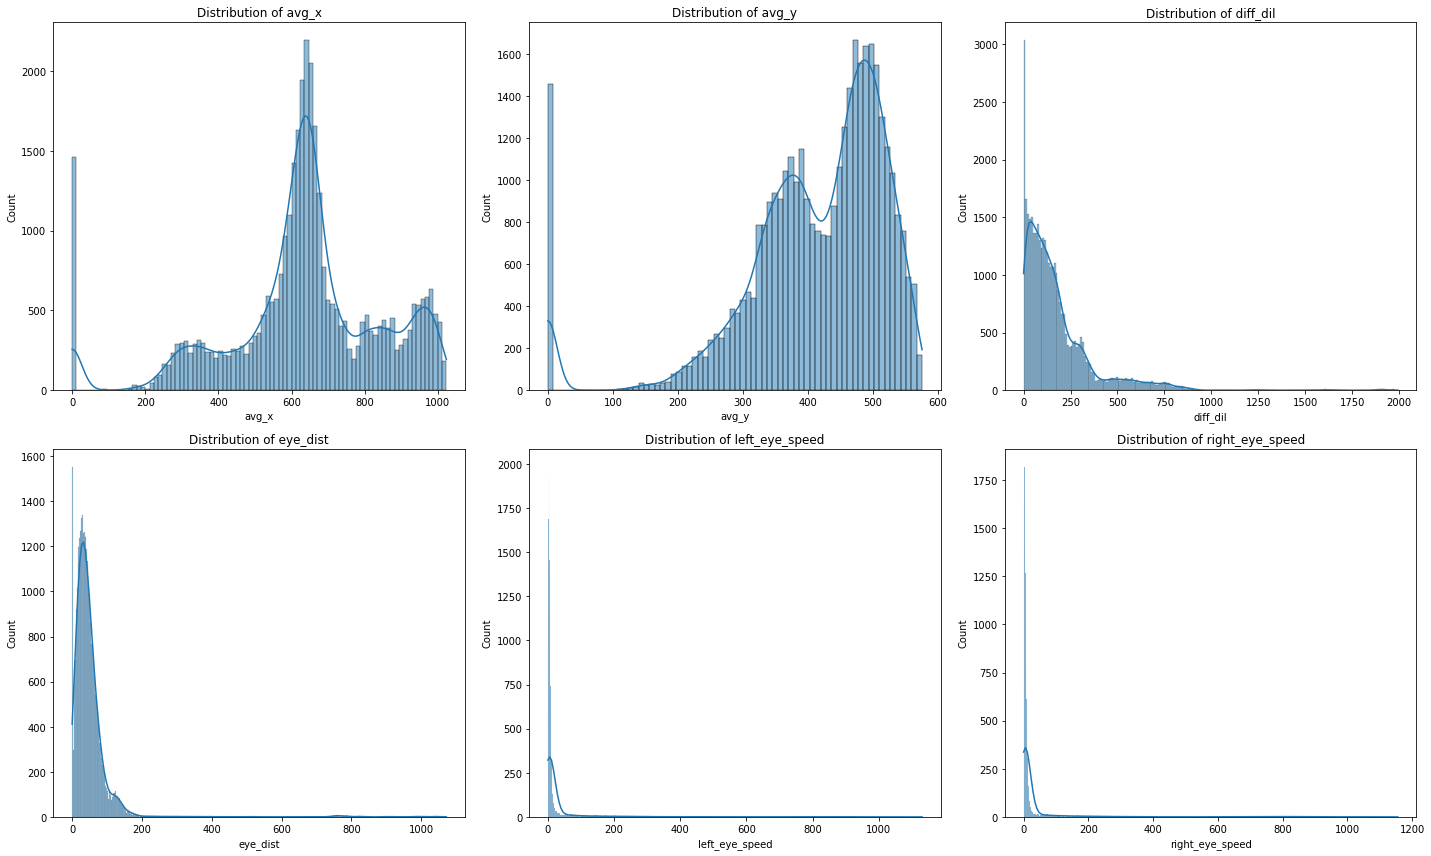

In [11]:
plt.figure(figsize=(20, 12))

#create subplots for each variable
variables = ['avg_x', 'avg_y', 'diff_dil', 'eye_dist', 'left_eye_speed', 'right_eye_speed']
#loop through the list of variables
for i, variable in enumerate(variables, 1):
    #create a subplot in a 2x3 grid 
    plt.subplot(2, 3, i)
    #plot a histogram with kernel density estimate for each variable,ref:https://seaborn.pydata.org/generated/seaborn.histplot.html
    sns.histplot(df_total[variable], kde=True)
    #set the title for each subplot
    plt.title(f'Distribution of {variable}')

plt.tight_layout()
plt.show()

The chart presents the distribution of different variables and their frequency:
1. The avg_x and avg_y charts show clear peaks, suggesting there were moments when participants’ gazes focused on particular screen areas.
2. Most data points for diff_dil approach smaller values, indicating that pupils were generally of similar size, with initial greater differences possibly due to visual stimuli.
3. eye_dist initially varies significantly, which may signify substantial shifts in the focus point, but later trends towards zero, suggesting a stabilized gaze point and quality eye-tracking data.
4. Distributions for left_eye_speed and right_eye_speed are also lower, implying stable eye movements overall, while higher initial speeds may correspond to rapid movements like blinks or fast scans, aligning with the initial fluctuations in eye_dist.

The distributions across various eye-tracking metrics highlight moments of focused attention, consistent pupil sizes, shifting and then stabilizing gaze points, along with generally stable eye movements.

##### 2. Observe the proportions of different event types through a pie chart.

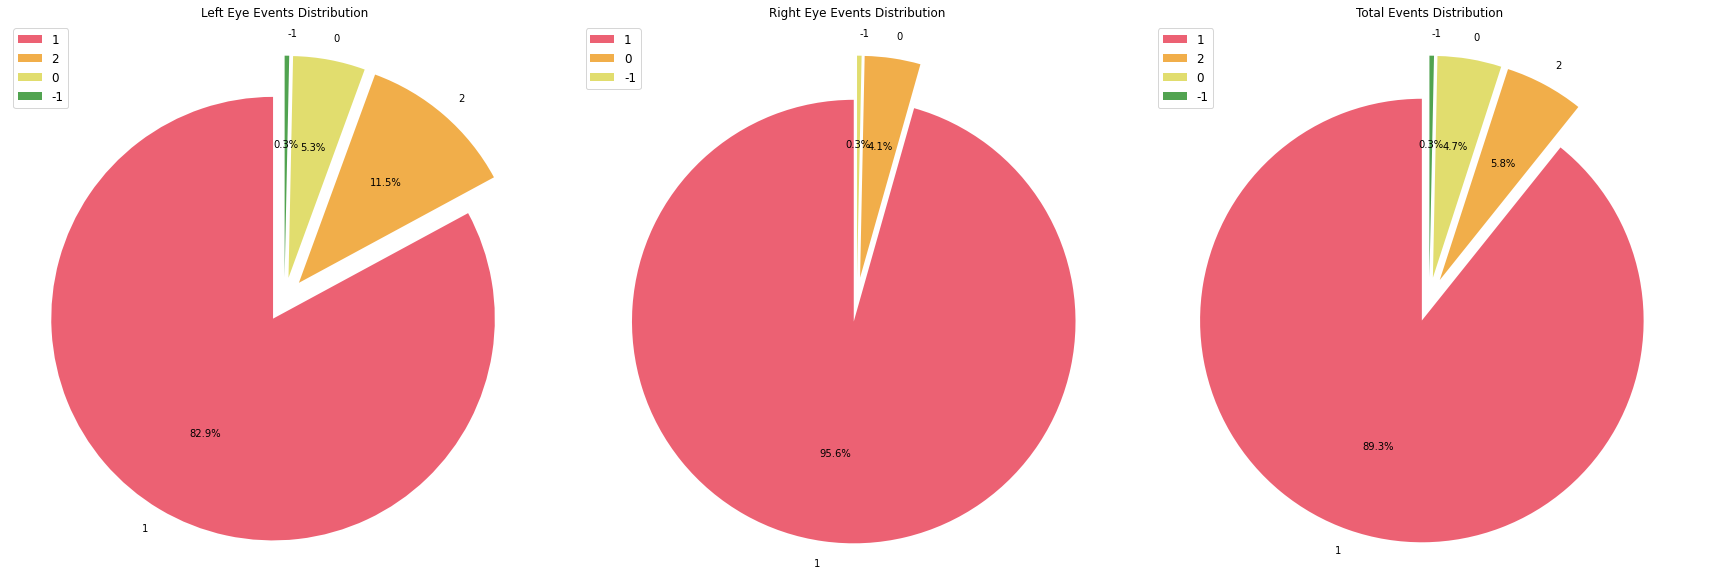

In [12]:
#create a subplot,ref:https://www.kaggle.com/code/sametardaerdogan/students-performance-eda-and-visualization/notebook
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

#calculate the distribution count of left eye events
left_event_counts = df_total['left_event'].value_counts()
#calculate the distribution count of right eye events
right_event_counts = df_total['right_event'].value_counts()

#calculate the total event distribution count,ref:https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
all_events = pd.concat([df_total['left_event'], df_total['right_event']])
total_event_counts = all_events.value_counts()

#plotting the distribution of left eye events
axs[0].pie(left_event_counts, explode=[0.1] * len(left_event_counts), labels=left_event_counts.index, autopct='%1.1f%%', startangle=90, colors=["#EC6173", "#F1AE4A", "#E1DD6E", "#51A350", "#6964FF", "#BD63BE"])
axs[0].set_title('Left Eye Events Distribution')
axs[0].legend(loc='upper left', fontsize=12)

#plotting the distribution of right eye events
axs[1].pie(right_event_counts, explode=[0.1] * len(right_event_counts), labels=right_event_counts.index, autopct='%1.1f%%', startangle=90, colors=["#EC6173", "#F1AE4A", "#E1DD6E", "#51A350", "#6964FF", "#BD63BE"])
axs[1].set_title('Right Eye Events Distribution')
axs[1].legend(loc='upper left', fontsize=12)

#plotting the total event distribution
axs[2].pie(total_event_counts, explode=[0.1] * len(total_event_counts), labels=total_event_counts.index, autopct='%1.1f%%', startangle=90, colors=["#EC6173", "#F1AE4A", "#E1DD6E", "#51A350", "#6964FF", "#BD63BE"])
axs[2].set_title('Total Events Distribution')
axs[2].legend(loc='upper left', fontsize=12)

#set the background color of the figure to white,ref:https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

It can be observed that fixation events dominate, which may indicate that participants were focusing on a fixed point for most of the time. The lower proportion of blinks and error frames suggests relatively high data recording quality and a lower frequency of blinking by participants.

##### 3. Utilize avg_x and avg_y (the central coordinates of the gaze) to understand the overall focal point of the gaze, analyzing the areas most frequently focused on by participants.

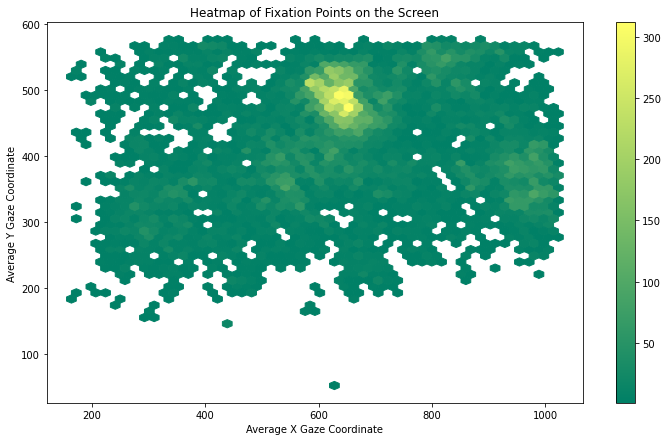

In [13]:
#set the size and resolution of the canvas
plt.figure(figsize=(12, 7))

#filter out all fixation events
fixation_data = df_total[(df_total['left_event'] == 1) & (df_total['right_event'] == 1)]

#generate a heatmap using the filtered data, ref:https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hexbin.html
plt.hexbin(fixation_data['avg_x'], fixation_data['avg_y'], gridsize=50, cmap='summer', mincnt=1)
#add a color bar 
plt.colorbar()
#set the title and axis labels
plt.title('Heatmap of Fixation Points on the Screen')
plt.xlabel('Average X Gaze Coordinate')
plt.ylabel('Average Y Gaze Coordinate')
plt.show()

This heatmap, derived from fixation data, shows where participants looked most frequently. Brighter spots reveal where gazes lingered longest, suggesting these areas held the most interest.

Initial observations indicate that participants' gaze primarily focuses within the range of 600-700 on the x-axis and 400-550 on the y-axis, implying that important information may be presented in this video segment. Consequently, I plan to delve deeper into the trend of the visual center (avg_x, avg_y) over time. This involves examining the positioning and duration of visual focus across a series of temporal sequences, correlating these findings with the video content to identify any significant information or visual elements that might attract participants' attention during those periods.

##### 4. Using Kernel Density Estimation (KDE) plots to validate the trend of visual center changes over time and demonstrate data point concentration within a region.

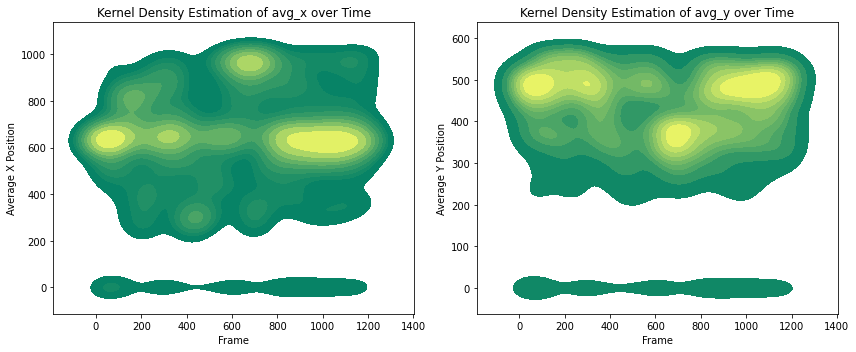

In [14]:
#set the size of the plot
plt.figure(figsize=(12, 5))

#plot the Kernel Density Estimation for the average X position over time, ref:https://seaborn.pydata.org/generated/seaborn.kdeplot.html
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_total, x='frame', y='avg_x', cmap='summer',fill=True)
plt.title('Kernel Density Estimation of avg_x over Time')
plt.xlabel('Frame')
plt.ylabel('Average X Position')

#plot the Kernel Density Estimation for the average Y position over time
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_total, x='frame', y='avg_y', cmap='summer',fill=True)
plt.title('Kernel Density Estimation of avg_y over Time')
plt.xlabel('Frame')
plt.ylabel('Average Y Position')

plt.tight_layout()
plt.show()

From the provided KDE plots, we can infer certain trends and concentrations of gaze points over time. In the left chart (showing changes in avg_x over time), we notice a high density around the value of 600 for avg_x in the initial 0-200 frames, and for avg_y, a high-density concentration around the value of 500. Subsequently, in the frames ranging from 600 to 1200, avg_x remains centered around 600, while avg_y appears concentrated between 300 to 600.

In [15]:
#calculate the average position of avg_x within the specific frame interval from 0 to 200
avg_x_mean_0_200 = df_total[(df_total['frame'] >= 0) & (df_total['frame'] <= 200)]['avg_x'].mean()
#calculate the average position of avg_x within the specific frame interval from 600 to 1200
avg_x_mean_600_1200 = df_total[(df_total['frame'] >= 600) & (df_total['frame'] <= 1200)]['avg_x'].mean()

#calculate the average position of avg_y within the specific frame interval from 0 to 200
avg_y_mean_0_200 = df_total[(df_total['frame'] >= 0) & (df_total['frame'] <= 200)]['avg_y'].mean()
#calculate the average position of avg_y within the specific frame interval from 600 to 1200
avg_y_mean_600_1200 = df_total[(df_total['frame'] >= 600) & (df_total['frame'] <= 1200)]['avg_y'].mean()

#print out the results
print(f'Average X position for frames 0-200: {avg_x_mean_0_200}')
print(f'Average X position for frames 600-1200: {avg_x_mean_600_1200}')
print(f'Average Y position for frames 0-200: {avg_y_mean_0_200}')
print(f'Average Y position for frames 600-1200: {avg_y_mean_600_1200}')

Average X position for frames 0-200: 618.2011787963098
Average X position for frames 600-1200: 655.2945695835664
Average Y position for frames 0-200: 430.57613852687075
Average Y position for frames 600-1200: 401.58811460822693


Taking both into account and considering the brief which states a frame rate of 30 frames per second, we can estimate that the 0-200 frame range corresponds to approximately the first 6.67 seconds of the video, while the 600-1200 frame range corresponds to approximately 20 to 40 seconds of video time. The corresponding average visual center areas are around (618, 430) and (655, 401), respectively. Observing the video, there is an entry of a bee into the frame in the upper right near midline area around 3-6 seconds, and between 20-26 seconds, there is a scene where a flower blooms and a bee enters, which likely attracted the participants' visual focus.

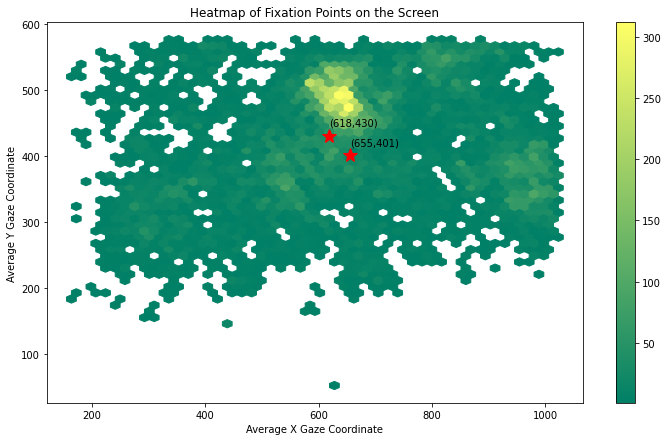

In [16]:
plt.figure(figsize=(12, 7))
#filter out all fixation events
fixation_data = df_total[(df_total['left_event'] == 1) & (df_total['right_event'] == 1)]

#generate a heatmap using the filtered data
plt.hexbin(fixation_data['avg_x'], fixation_data['avg_y'], gridsize=50, cmap='summer', mincnt=1)
#add a color bar
plt.colorbar()
#annotate coordinates points and their locations,ref:https://www.geeksforgeeks.org/matplotlib-pyplot-annotate-in-python/
points = [(618, 430), (655, 401)]
for point in points:
    plt.plot(point[0], point[1], 'r*', markersize=15)
    plt.annotate(f'({point[0]},{point[1]})', point,textcoords="offset points", xytext=(0,10),ha='left')               

plt.title('Heatmap of Fixation Points on the Screen')
plt.xlabel('Average X Gaze Coordinate')
plt.ylabel('Average Y Gaze Coordinate')
plt.show()

By annotating the heatmap with average visual focus points segmented by specific time intervals, we gain an intuitive understanding of the participants' gaze patterns throughout the video timeline. 

However, there is a noticeable divergence between these coordinates and the brightest areas of the heatmap, suggesting that these points represent the centers of visual attention only at certain times, rather than consistently throughout the entire viewing period. The heatmap aggregates all gaze data, and if visual elements were to move—like a bee in flight—the gaze of the participants would follow this motion, resulting in concentrated fixations at particular times but not necessarily depicting the average focus over time. This difference highlights the necessity to differentiate between sequential and cumulative data analysis in eye-tracking research. The indicated points mark significant visual attractions within particular time frames, but they do not necessarily represent the main focus of attention across the entire video, underscoring the dynamic nature of visual attention.

##### 5. Analyzing Individual Gaze Patterns Over Time

To study each participant's eye movement and find common patterns, we can group data by 'participant'. The 'avg_x' and 'avg_y' columns show the visual center's x and y coordinates, letting us track each participant's gaze changes over time.

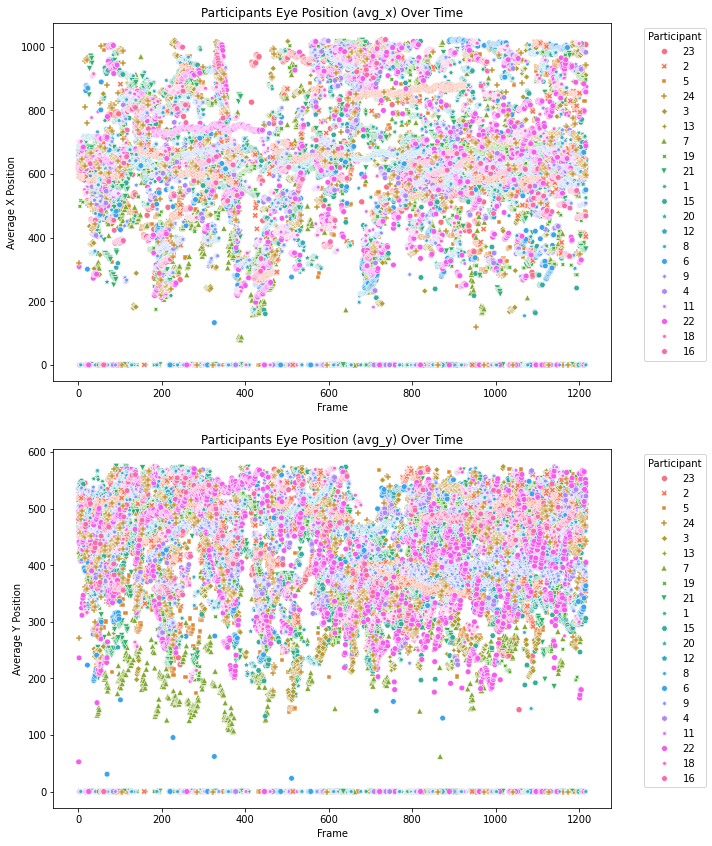

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

#plot a scatter plot of the left eye's x coordinate over time，ref:https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.scatterplot(x='frame', y='avg_x', hue='participant', style='participant', data=df_total, ax=axes[0])
axes[0].set_title('Participants Eye Position (avg_x) Over Time')
axes[0].set_xlabel('Frame')
axes[0].set_ylabel('Average X Position')
axes[0].legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')

#plot a scatter plot of the right eye's x coordinate over time
sns.scatterplot(x='frame', y='avg_y', hue='participant', style='participant', data=df_total, ax=axes[1])
axes[1].set_title('Participants Eye Position (avg_y) Over Time')
axes[1].set_xlabel('Frame')
axes[1].set_ylabel('Average Y Position')
axes[1].legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Although it's still apparent that avg_x is concentrated around the position of 600, and avg_y is centered between 400 and 500, the graph appears very crowded due to the large number of points. The data points from different participants overlap significantly, making it difficult to discern individual differences or specific variations between participants. Therefore, I plan to separate out the participants and randomly select six to create subplots for further analysis.

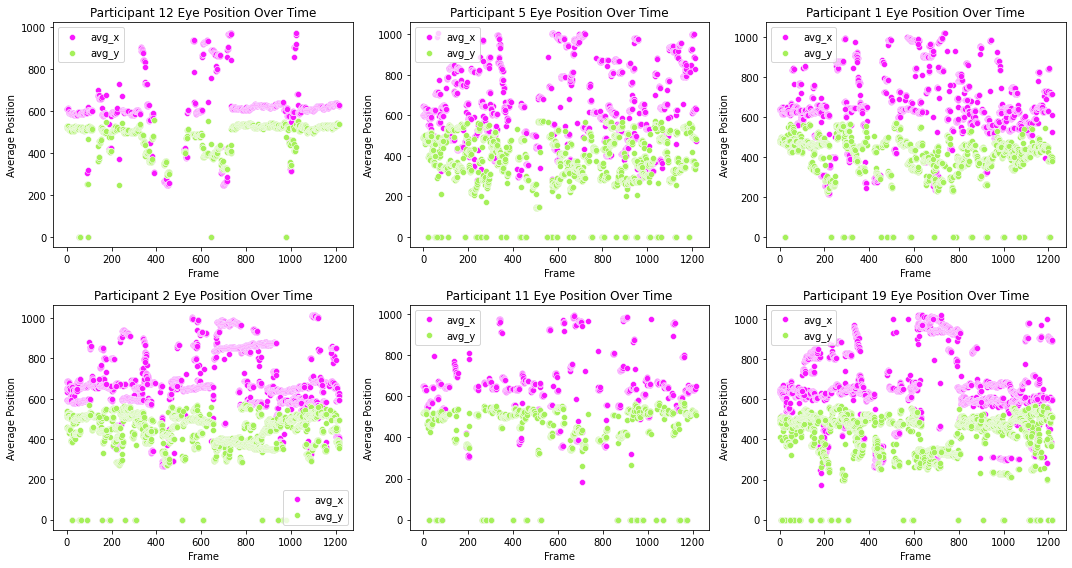

In [19]:
#number of participants and data points we're using
n_participants = 24
n_points = 100

#randomly select 6 different participants,ref:https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
selected_participants = np.random.choice(df_total['participant'].unique(), 6, replace=False)
#filter the data for these selected participants
df_selected = df_total[df_total['participant'].isin(selected_participants)]

plt.figure(figsize=(15, 8))
#loop through each of the selected participants to create subplots
for i, participant in enumerate(selected_participants, 1):
    #create a subplot for each participant
    plt.subplot(2, 3, i)
    #get the data for the current participant
    participant_data = df_selected[df_selected['participant'] == participant]
    #plot avg_x and avg_y on the same subplot with different colors
    sns.scatterplot(x='frame', y='avg_x', data=participant_data, color="#F817FF", label='avg_x')
    sns.scatterplot(x='frame', y='avg_y', data=participant_data, color="#A5F05A", label='avg_y')
    plt.title(f'Participant {participant} Eye Position Over Time')
    plt.xlabel('Frame')
    plt.ylabel('Average Position')
    plt.legend()

plt.tight_layout()
plt.show()

This set of charts displays the eye movement trajectories of six participants, namely the changes in the X coordinates of their visual centers over time. Observing the charts, we find that the visual center positions of most participants are mainly concentrated around the 600 mark on the X-axis and approximately 400 on the Y-axis. Despite some dispersion, the gaze remains focused near this area for most of the time. This may suggest that during observation, participants' gazes are largely focused on a specific part of the screen, consistent with previous analyses. We also note that at different time points, some data points are abnormally concentrated near x=0. These anomalies could represent sudden shifts in participants' gaze to other areas of the screen, or they may be errors in the data collection or processing.

 Notably, participants 11 and 12 have a significantly lower number of data points, which could suggest that they frequently looked away from the screen during viewing or that outliers were removed during data processing. To draw more precise conclusions, we need to conduct an in-depth analysis of the video content and may need to process the eye-tracking data more meticulously.

##### 6. Compare the average values of eye movement speed between different participants.

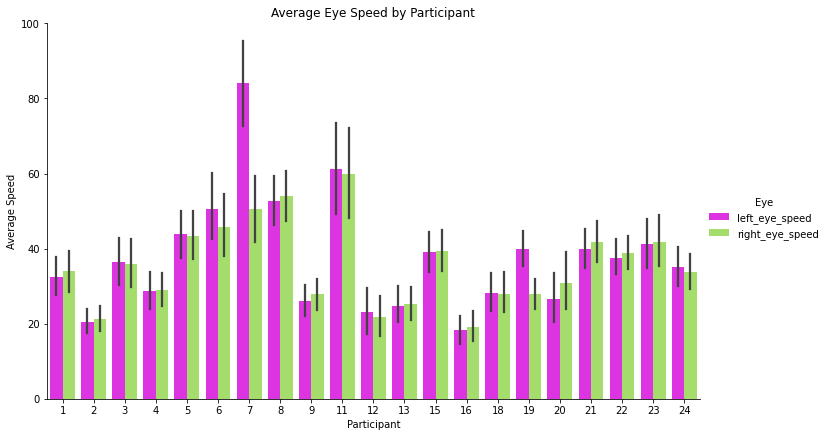

In [20]:
#create a new DataFrame containing participant identifiers and the speeds of the left and right eyes, using .copy() to avoid modifying the original data
df_speed = df_total[['participant', 'left_eye_speed', 'right_eye_speed']].copy()

#ensure the participant column is of integer type for consistent sorting and analysis
df_speed['participant'] = df_speed['participant'].astype(int)
#sort the DataFrame by participant number 
df_speed_sorted = df_speed.sort_values(by='participant')
#transform the data from a wide format to a long format,ref:https://deepnote.com/app/yasser-alwan-640e/freecodecamporg-or-Medical-Data-Visualizer-c126f448-8d97-428f-bcfe-77defba1e584
df_long_format_sorted = pd.melt(df_speed_sorted, id_vars=['participant'], value_vars=['left_eye_speed', 'right_eye_speed'], var_name='Eye', value_name='Speed')

# Create a categorical plot with seaborn
sns.catplot(data=df_long_format_sorted, x="participant", y="Speed", hue="Eye", kind="bar", height=6, aspect=10/6, palette={"left_eye_speed": '#F817FF', "right_eye_speed":'#A5F05A'})
plt.title('Average Eye Speed by Participant')
plt.xlabel('Participant')
plt.ylabel('Average Speed')
plt.show()

This chart showcases average speeds of participants' left and right eyes, indicating similar speeds for both eyes among most participants but highlighting differences, especially in participant 7 where the left eye is significantly faster.  This reflects individual differences in eye movement.  Generally, left and right eye speeds are expected to be similar, with error bars showing variability, particularly at higher speeds, suggesting greater measurement variation with increased speed.

##### 7. Exploring Gaze Patterns: Participant-Specific Boxplots of Average Gaze Coordinates

<ipython-input-21-443ae04dbd3b>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='participant', y=feature, data=df_total, ax=axes[i], palette=palette, fliersize=0, flierprops=flierprops)
<ipython-input-21-443ae04dbd3b>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='participant', y=feature, data=df_total, ax=axes[i], palette=palette, fliersize=0, flierprops=flierprops)


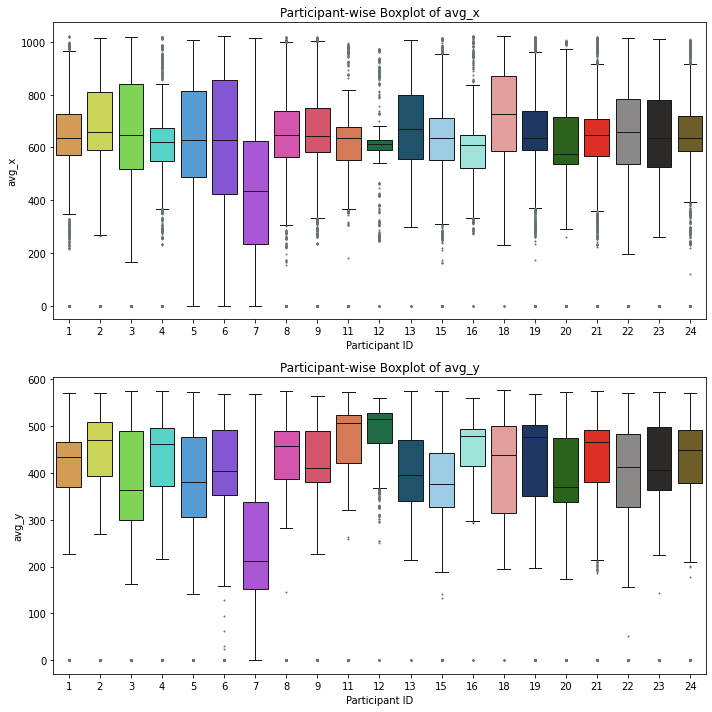

In [21]:
#ensure the participant column is of integer type
df_total['participant'] = df_total['participant'].astype(int)
#sort the dataframe by participant ID
df_total = df_total.sort_values(by='participant')

#select the features we are interested in for visualization
features_to_plot = ['avg_x', 'avg_y']
#assign a color for each subplot
colors = ['#E99D41','#DCE941','#76E941','#41E9DC','#419FE9','#7E41E9','#B141E9','#E941B4','#E94160','#E97141','#127944','#125879','#91D1F0','#91F0E3','#F09191','#11356F','#246F11','#FB1308','#8B8787','#2C2828','#78631D']

#create a color dictionary to ensure each unique participant in df_total is assigned a color
unique_participants = df_total['participant'].unique()
palette = {str(participant): color for participant, color in zip(unique_participants, colors)}
#create a canvas and arrange the subplots
fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(10, 5 * len(features_to_plot)))
#set the style for outliers
flierprops = dict(marker='o', markerfacecolor='#677172', markersize=2, linestyle='none', markeredgecolor='none')
#loop through each feature and plot boxplots for each participant
for i, feature in enumerate(features_to_plot):
    sns.boxplot(x='participant', y=feature, data=df_total, ax=axes[i], palette=palette, fliersize=0, flierprops=flierprops)
    axes[i].set_title(f'Participant-wise Boxplot of {feature}')
    axes[i].set_xlabel('Participant ID')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

The boxplot suggests that participant 7 displays the most varied gaze pattern, with focal point notably lower on the screen, leaning towards the bottom center. This indicates a consistent viewing behavior within a specific screen region, with a lack of outliers underscoring this consistency.

In contrast, participants 6 and 12 show a number of outliers in their vertical gaze (avg_y), hinting at occasional shifts of attention away from the screen. While the horizontal gaze (avg_x) is quite uniform among participants, reflecting a consensus in focus, the variation in avg_y’s median values across participants points to a diverse vertical engagement. These insights are crucial for revealing patterns of consistency and individual variability in viewing behavior.

##### 8. Explore the frequency of different event types for each participant

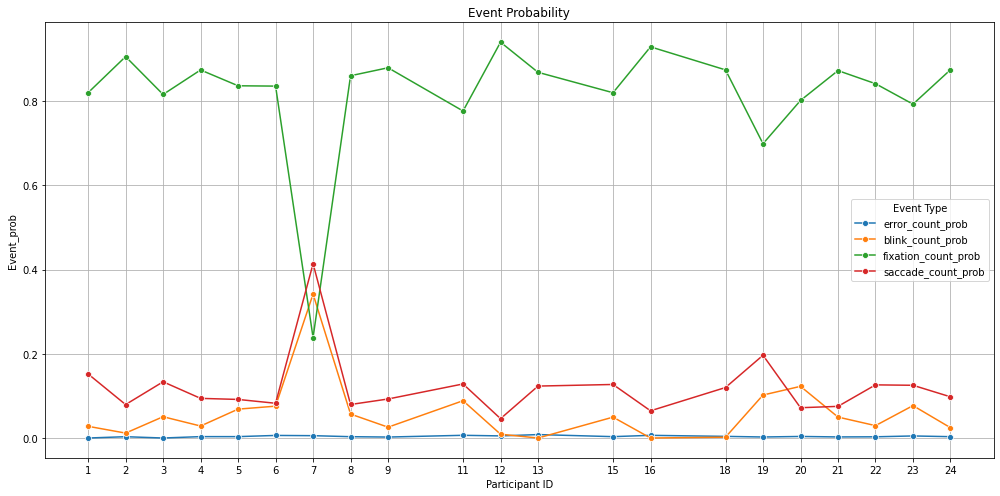

In [23]:
#ensure the participant column is of integer type 
df_total['participant'] = df_total['participant'].astype(int)
#sort the DataFrame by participant identifier
df_total = df_total.sort_values(by='participant')

#define the columns that contain event counts
event_columns = ['error_count', 'blink_count', 'fixation_count', 'saccade_count']
#group the data by participant and calculate the total counts for each event type
df_events = df_total.groupby('participant')[event_columns].sum().reset_index()

#calculate the probability of occurrence for each event type for each participant
total_events = df_events[event_columns].sum(axis=1)
for event in event_columns:
    #create a new column for each event type's probability
    df_events[event + '_prob'] = df_events[event] / total_events

#transform the DataFrame from wide to long format, suitable for line plotting
df_long = pd.melt(df_events, id_vars='participant', value_vars=[col + '_prob' for col in event_columns],var_name='event_type', value_name='event_probability')

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_long, x='participant', y='event_probability', hue='event_type', marker='o')
#set x-axis tick labels
plt.xticks(ticks=df_long['participant'].unique(), labels=df_long['participant'].unique())
plt.title('Event Probability')
plt.xlabel('Participant ID')
plt.ylabel('Event_prob')
#display the legend to identify different event types
plt.legend(title='Event Type')
#add gridlines to the plot for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

The graph reveals the probability variation among different participants for each event type (errors, blinks, fixations, and saccades). Generally, fixation events appear to dominate among most participants, which might suggest that the video content is relatively steady and lacks sufficient visual stimuli to cause significant changes in visual behavior. For participant 7, the probability of fixation is significantly lower than others, with a relative increase in blinks and saccades, possibly indicating a more dispersed attention to the video content or a different approach to processing information.

Moreover, the probability of error events is overall low, which might indicate generally good performance by the participants during the task, or high quality in data collection and processing. 

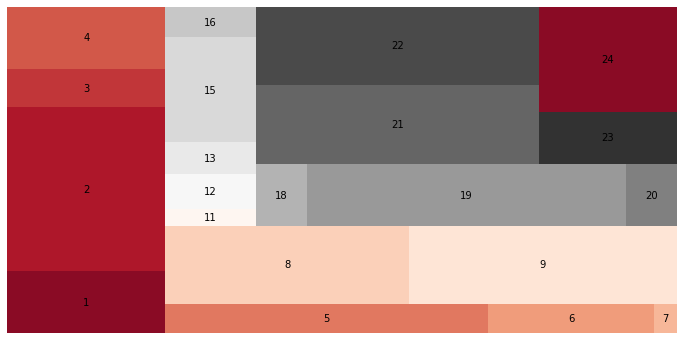

In [24]:
#group by participant and calculate the sum of fixation counts for each participant
participant_fixation = df_total.groupby('participant')['fixation_count'].sum()

plt.figure(figsize=(12, 6))
#use the squarify library to generate a treemap, where the 'sizes' parameter represents each participant's fixation counts,ref:https://python-charts.com/part-whole/treemap-matplotlib/?utm_content=cmp-true
squarify.plot(sizes=participant_fixation.values, label=participant_fixation.index, linewidth=4,
              color=sns.color_palette("RdGy", n_colors=20))
plt.axis('off')
plt.show()

This treemap displays the fixation counts for each participant, represented by rectangles of varying sizes. The larger the rectangle, the higher the fixation count, swiftly communicating which participants have higher fixation counts during the viewing process. This may reflect the participants' level of attention to the visual content or the varying attractiveness of the video content.

From the graph, we can see that participant 7 has the fewest fixation counts, consistent with the previous line chart, indicating a tendency for more blinking or saccades. This may suggest that his attention is more scattered or that the video content is less engaging for him. Participants such as 2, 22, 24, and 21 have significantly more fixations than others, potentially indicating a stronger interest in the video content or a viewing preference for fixating rather than scanning.

##### 9. Analyze the relationship between pupil size variations and specific events such as fixations or saccadic movements.

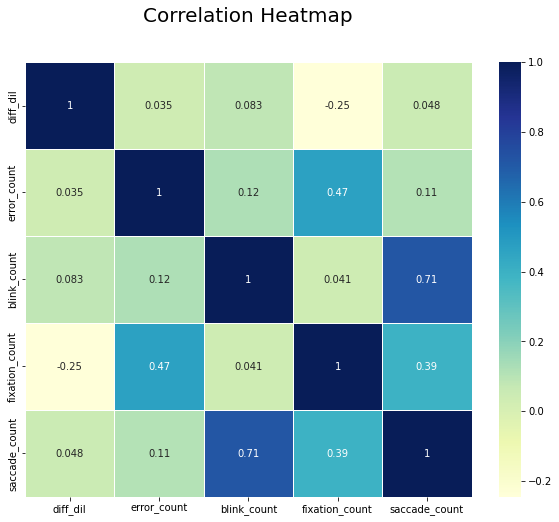

In [25]:
#select the column names of interest,ref:https://stackoverflow.com/questions/39409866/correlation-heatmap
columns_of_interest = ['diff_dil', 'error_count', 'blink_count', 'fixation_count', 'saccade_count']
#generate a correlation matrix
corr_matrix = df_total[columns_of_interest].corr()

plt.figure(figsize=(10, 8))
plt.title('Correlation Heatmap', color='black', fontsize=20, pad=40)
#draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.show()

This correlation heatmap displays the coefficients between various variables in the dataset. The color gradient—from deep blue indicating a stronger positive correlation to white indicating a weaker or no correlation—visualizes the strength of the relationships.

There appears to be a notable positive correlation between diff_dil and blink_count as suggested by the deeper color, which may indicate an increase in pupil size variation during blinking events. However, the correlation between diff_dil and both fixation_count and saccade_count is less pronounced (nearing white), suggesting no significant direct link between pupil dilation changes and the occurrence of fixations or saccades.

To continue investigating the influence of 'blink_count' on 'diff_dil'.

In [26]:
x = df_total['blink_count']
y = df_total['diff_dil']

#adding a constant term to the independent variable, because OLS by default does not include a constant term,ref:https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
x = sm.add_constant(x)
#creating the model and fitting the data to it
model = sm.OLS(y, x).fit()

#print the model's summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               diff_dil   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     260.2
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           2.41e-58
Time:                        16:42:39   Log-Likelihood:            -2.5033e+05
No. Observations:               37287   AIC:                         5.007e+05
Df Residuals:                   37285   BIC:                         5.007e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         154.7446      1.675     92.370      

The OLS regression results provide a quantified analysis of the relationship between diff_dil and blink_count. Based on the results we can conclude:
The coefficient for const is 154.7446 with a std err of 1.675. This means that, without considering the impact of blinking, the baseline value for pupillary dilation difference is 154.7446. The coefficient for blink_count is 0.2113 with a standard error of 0.013, indicating that for each additional blink, the average increase in pupillary dilation difference is 0.2113 units. The P-value for blink_count is far less than 0.05, suggesting that the number of blinks has a statistically significant impact on pupillary dilation difference. The R-squared value is 0.007, meaning that blink_count explains only 0.7% of the variability in pupillary dilation difference, which implies a very low explanatory power of the model. The Durbin-Watson statistic is 0.507, which may indicate positive autocorrelation in the data. The P-values for the Omnibus and JB tests are close to 0, suggesting that the residuals do not follow a normal distribution, which might mean there are issues with the model specification or outliers in the data.

Thus, even though the number of blinks has a statistically significant effect on pupillary dilation difference, the overall explanatory power of the model is weak (R-squared = 0.007). This might indicate that there are other unconsidered factors affecting pupillary dilation difference, or that pupillary dilation difference is influenced by a combination of multiple factors.

Further examine the data and model assumptions (such as normality and independence of residuals) to explore the explanatory power and predictive accuracy of the model.

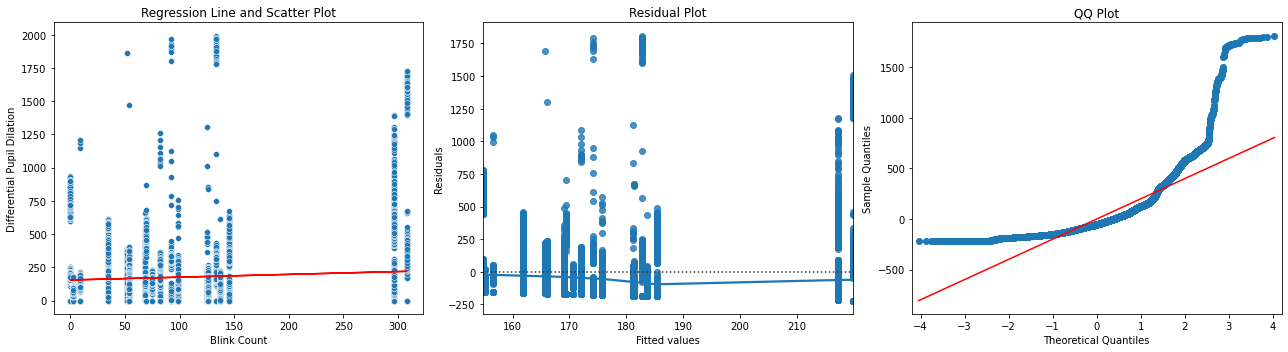

In [27]:
X = df_total['blink_count']
y = df_total['diff_dil']

#add a constant term
X_const = sm.add_constant(X)
#build and fit the model
model = sm.OLS(y, X_const).fit()

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
#the first subplot: scatter plot and regression line
sns.scatterplot(x=X, y=y, ax=axs[0])
#plot the regression line
axs[0].plot(X, model.predict(X_const), color='red')
axs[0].set_xlabel('Blink Count')
axs[0].set_ylabel('Differential Pupil Dilation')
axs[0].set_title('Regression Line and Scatter Plot')

#the second subplot: residual plot,ref:https://seaborn.pydata.org/generated/seaborn.residplot.html
sns.residplot(x=model.predict(), y=model.resid, lowess=True, ax=axs[1])
axs[1].set_xlabel('Fitted values')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residual Plot')

#the third subplot: QQ plot,ref:https://stackoverflow.com/questions/13865596/quantile-quantile-plot-using-scipy
qqplot(model.resid, line='s', ax=axs[2])
axs[2].set_title('QQ Plot')
plt.tight_layout() 
plt.show()

From these three graphs, we can observe that:

The scatter plot and regression line indicate a positive relationship between blink_count and diff_dil; however, the data points are highly dispersed, suggesting that many other factors may also be influencing diff_dil. The near-horizontal regression line is consistent with the low R-squared value (0.007), indicating that blink_count has limited explanatory power for the variability in diff_dil.

The residual plot shows the relationship between the fitted values and the residuals observed. The plot clearly exhibits that the residuals are not evenly distributed, especially increasing as the fitted values increase, which may indicate the presence of heteroscedasticity or that the model has not captured all the information in the data. 

The QQ plot is used to compare the distribution of the data with a normal distribution. In this plot, the data points significantly deviate from the red reference line, indicating that the residuals' distribution significantly deviates from normality. The plot shows that residuals in the lower and upper quantiles particularly deviate, implying the presence of outliers or a heavy-tailed distribution in the data.

Based on these charts, we can infer that the model may not be the optimal choice as it does not adequately explain the variability in the data, has potential heteroscedasticity, and the distribution of residuals violates the assumption of normality. This may mean that a more complex model needs to be considered.

##### 10. Building predictive models

In [28]:
#select potential predictor variables
predictors = ['blink_count', 'fixation_count', 'saccade_count', 'left_eye_speed', 'right_eye_speed']
#remove rows with missing data,ref:https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
df_clean = df_total[np.hstack((predictors, 'diff_dil'))].dropna()

#define the response variable and predictor variables,ref:https://www.statsmodels.org/devel/glm.html
X = sm.add_constant(df_clean[predictors])
#response variable
y = df_clean['diff_dil']
#create a Generalized Linear Model
glm = sm.GLM(y, X, family=sm.families.Gaussian())
#fit the model
results = glm.fit()
#print the percentage of explained variance
print('Explained variance: {:.1f}%'.format(100 * (1 - np.var(results.resid_pearson) / np.var(y))))
#display the model summary
print(results.summary())

Explained variance: 8.8%
                 Generalized Linear Model Regression Results                  
Dep. Variable:               diff_dil   No. Observations:                37286
Model:                            GLM   Df Residuals:                    37280
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                          36460.
Method:                          IRLS   Log-Likelihood:            -2.4873e+05
Date:                Fri, 15 Mar 2024   Deviance:                   1.3592e+09
Time:                        16:46:21   Pearson chi2:                 1.36e+09
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09232
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            

The results from this GLM provide a statistical analysis of the relationship between diff_dil and several eye movement indicators. 

The coefficient for blink_count is negative (-0.1627), suggesting that an increase in the number of blinks is associated with a decrease in the average pupil dilation difference, which may imply a link between blinking and pupil constriction. fixation_count also has a negative coefficient (-0.1048), indicating that more fixation events might be related to smaller pupil dilation variations.In contrast, saccade_count has a positive coefficient (0.3589), suggesting that an increase in saccadic events could be associated with an increase in pupil dilation difference.The coefficients for left_eye_speed and right_eye_speed are 0.1521 and -0.1597, respectively, suggesting that increased speed of the left eye correlates with an increase in pupil dilation difference, while an increase in the right eye speed correlates with a decrease. However, the negative correlation for right eye speed might require further investigation as it's generally expected that the behavior of both eyes would be similar.

These results provide insight into how various eye movement events influence pupil dilation variation. It's crucial to recognize that the findings suggest correlations rather than causation. Moreover, the model's explained variance stands at 8.8%, meaning it only accounts for a small portion of the total variance. This modest explained variance hints at the presence of additional factors not encompassed by the model that may also affect pupil dilation differences.

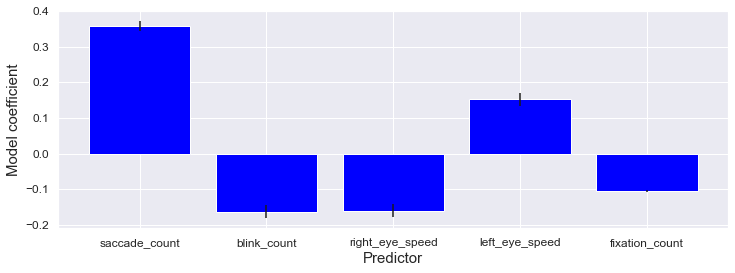

In [113]:
#actual parameter values and standard errors from the model results
coef = np.array([-0.1627, -0.1048, 0.3589, 0.1521, -0.1597])
events = np.array(['blink_count', 'fixation_count', 'saccade_count', 'left_eye_speed', 'right_eye_speed'])
std = np.array([0.019, 0.002, 0.014, 0.019, 0.019])

#identify indices that would sort the coefficients by their absolute values in descending order,ref:https://stackoverflow.com/questions/54016664/how-exactly-abs-and-argsort-works-together
idx = np.argsort(-np.abs(coef))
#sort the coefficients, event names, and standard errors according to the sorted indices
sorted_params_values = coef[idx]
sorted_params_names = events[idx]
sorted_bse_values = std[idx]

#visualize the model coefficients
plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(sorted_params_values)), sorted_params_values, color='blue', yerr=sorted_bse_values)
plt.xticks(np.arange(len(sorted_params_values)), sorted_params_names, size=12)
plt.yticks(size=12)
plt.xlabel('Predictor', size=15)
plt.ylabel('Model coefficient', size=15)
plt.show()

The bar graph visualizes the extent to which various eye movement indicators influence diff_dil. The height of each bar represents the coefficient of the predictor in the regression model, and the error bars above each bar represent the standard errors of these coefficients.

The saccade_count has the highest positive coefficient, indicating a strong positive relationship between the frequency of saccades and an increase in pupil dilation difference. left_eye_speed also has a positive coefficient, though its effect is relatively smaller, suggesting that faster movement of the left eye is associated with an increase in pupil dilation difference, yet to a lesser extent than saccades. Both blink_count and right_eye_speed have negative coefficients, implying that an increase in these movements is associated with a decrease in pupil dilation difference. This might indicate that blinking and rapid movement of the right eye are linked to pupil constriction. The coefficient for fixation_count is also negative, suggesting an increase in the number of fixations is correlated with a reduction in pupil dilation difference, possibly reflecting the stability of the pupil during fixation. Additionally, the short error bar for fixation_count suggests a high degree of confidence in this particular coefficient, as it indicates low variability and uncertainty in its estimate.

Overall, this chart helps us understand the relationship between eye movements and pupil dilation, with each metric contributing differently to changes in pupil size. ​

### LLM disclaimer

I utilized large language models (LLMs) as an auxiliary tool, which assisted me in fixing errors in the code, as well as in translating the essay writing.